In [1]:
import numpy as np 
import pandas as pd 

import time

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score 

import matplotlib.pyplot as plt
import seaborn as sns

import random

import os

import tensorflow as tf
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.layers import Dense , Flatten, Conv2D, MaxPooling2D, Dropout, Input , BatchNormalization ,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("noodulz/pokemon-dataset-1000")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Aryan\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2


In [3]:
path = str(path)
dataset_path = path + '/pokemon-dataset-1000/dataset'
train_path = path + '/pokemon-dataset-1000/train'
test_path = path + '/pokemon-dataset-1000/test'
val_path = path + '/pokemon-dataset-1000/val'

In [4]:
label = []
path = []
main_dir = dataset_path
for i in os.listdir(main_dir):
    for img in os.listdir(f"{main_dir}/{i}"):
        label.append(i)
        path.append(f"{main_dir}/{i}/{img}")

In [5]:
df = pd.DataFrame(columns=['label', 'path'])
df['label'] = label
df['path'] = path

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26539 entries, 0 to 26538
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   26539 non-null  object
 1   path    26539 non-null  object
dtypes: object(2)
memory usage: 414.8+ KB


In [7]:
df.nunique()

label     1000
path     26539
dtype: int64

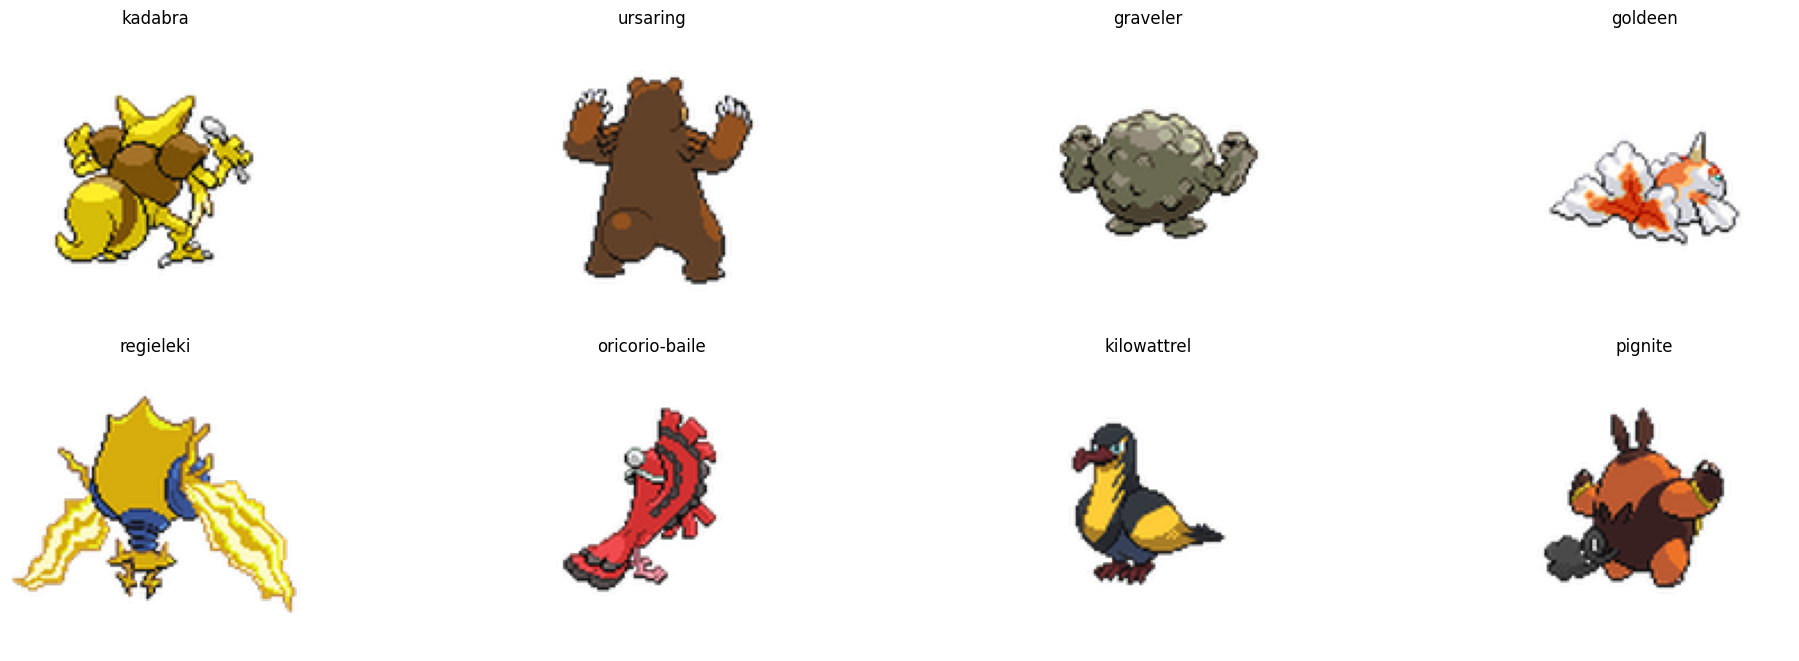

In [8]:
# displaying random pokemon images
rand_labels = random.sample(df['label'].unique().tolist(), 8)

plt.figure(figsize=(20, 10))
for idx, label in enumerate(rand_labels):
    plt.subplot(3, 4, idx + 1)
    img_path = df[df['label'] == label].iloc[0, 1]
    plt.imshow(plt.imread(img_path))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# checking for image dimensions of random pokemon to confirm uniformity
from PIL import Image

rand_imgs = random.sample(list(df['path']), 1000)

img_shapes = []

for img_path in rand_imgs:
    img = Image.open(img_path)
    img_shapes.append(img.size)

widths, heights = zip(*img_shapes)

avg_shape = np.mean(widths), np.mean(heights)

print(f"Average image shape: {avg_shape}")

Average image shape: (128.0, 128.0)


In [10]:
df['label']

0         abomasnow
1         abomasnow
2         abomasnow
3         abomasnow
4         abomasnow
            ...    
26534    zygarde-50
26535    zygarde-50
26536    zygarde-50
26537    zygarde-50
26538    zygarde-50
Name: label, Length: 26539, dtype: object

In [11]:
# label encoding

labels = df['label'].astype('category').cat.codes 
df['label_encoded'] = labels

img_size = (128, 128)

images = []
for i in df['path']:
    img = load_img(i, target_size=img_size)
    img = img_to_array(img)
    img = img / 255.0 # Normalizing the pixel values (from 0 to 225 to 0 to 1)
    images.append(img)

X = np.array(images)
y = df['label_encoded']

# .astype('category'): This converts the data type of the 'label' column to the Pandas category data type. 
# This is crucial because it tells Pandas to treat the values in this column as distinct categories, not just strings or numbers.  
# This step is important for the next operation.

# .cat.codes: This is the key part.  The .cat accessor is used specifically for columns of the category data type.  
# The .codes attribute returns a NumPy array of integers.  Each unique category in the original column is assigned a unique integer code.  
# These codes start from 0 and go up to the number of unique categories minus 1.

# labels = ...: Finally, the resulting NumPy array of integer codes is assigned to the variable labels.

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=42, stratify = y)

In [13]:
print(f"X_train shape: {xtrain.shape}\nX_test shape: {xtest.shape}\nY_train shape: {ytrain.shape}\nY_test shape: {ytest.shape}")

X_train shape: (22558, 128, 128, 3)
X_test shape: (3981, 128, 128, 3)
Y_train shape: (22558,)
Y_test shape: (3981,)


In [14]:
ytest.nunique()

1000

In [15]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# The selected code computes class weights for an imbalanced dataset and converts them into a dictionary
# using the dict(enumerate(class_weights)) function. The class weights are calculated using the compute_class_weight function

# ---------------------------------------------------------

# compute_class_weight:
# ----------------------
# Calculates weights for each class to handle class imbalance.
# class_weight='balanced' ensures weights are inversely proportional to class frequencies.
# classes=np.unique(y_train) provides unique class labels.
# y=y_train is the array of class labels.

# ---------------------------------------------------------

# dict(enumerate(class_weights)):
# ----------------------
# Converts the list of class weights into a dictionary where keys are class indices and values are the weights.

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(ytrain),
    y=ytrain
)
class_weights_dict = dict(enumerate(class_weights))

In [16]:
print(ytrain.shape,"\n",ytest.shape)

(22558,) 
 (3981,)


# **EfficientNet**

In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

Effnetmodel = Sequential([
    base_model,  
    GlobalAveragePooling2D(), 
    BatchNormalization(),
    Dense(256, activation='relu', name="Layer1"),
    BatchNormalization(),
    Dropout(0.5), 
    Dense(128, activation='relu', name="Layer2"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1000, activation='softmax', name="output_layer")
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
Effnetmodel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
def image_generator(X, y, batch_size, class_weights):
    while True:
        
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            
            
            sample_weights = np.array([class_weights.get(label, 1.0) for label in y_batch])

            yield X_batch, y_batch, sample_weights

In [20]:
start_time = time.time()

history = Effnetmodel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 186ms/step - accuracy: 0.0035 - loss: 6.9230 - val_accuracy: 0.0015 - val_loss: 6.9833
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 174ms/step - accuracy: 0.0655 - loss: 5.8929 - val_accuracy: 0.0018 - val_loss: 7.1499
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - accuracy: 0.2282 - loss: 4.4479 - val_accuracy: 0.0454 - val_loss: 6.0562
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.4246 - loss: 3.0913 - val_accuracy: 0.2658 - val_loss: 3.7313
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.5936 - loss: 2.0282 - val_accuracy: 0.7737 - val_loss: 1.2141
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.7169 - loss: 1.3573 - val_accuracy: 0.8920 - val_loss: 0.5541
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.8135 - loss: 0.8928 - val_accuracy: 0.9180 - val_loss: 0.4197
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.8724 - loss: 

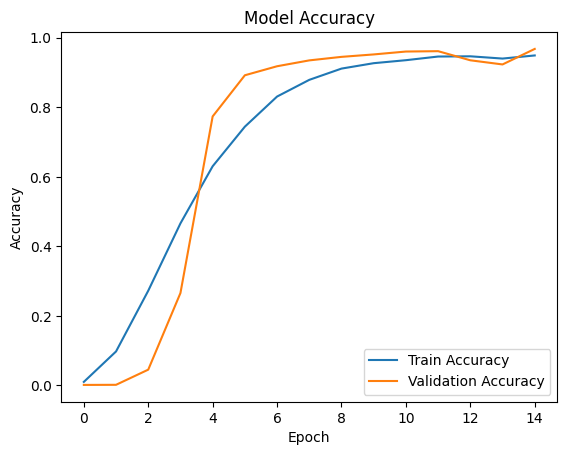

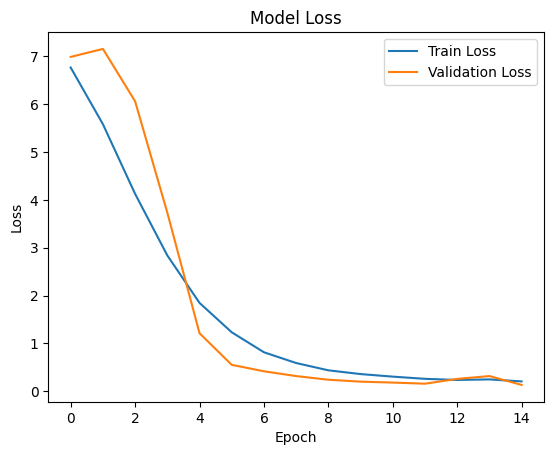

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
xtest[0].shape

(128, 128, 3)

In [23]:
start_time = time.time()

pred = Effnetmodel.predict(np.expand_dims(xtest[0], axis=0))

end_time = time.time()
inference_time = end_time - start_time

y_pred = Effnetmodel.predict(xtest)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
Weighted Average F1 Score: 0.9667


In [24]:
Effnetmodel.save("EfficientNet.h5")

In [25]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 512.9842450618744 
Inference Time: 5.520990610122681


# **Xception Model** # 

In [26]:
# Load the Xception model without the top (fully connected) layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x) # Fully connected layer
predictions = Dense(1000, activation='softmax')(x)  # Output layer

# Create the final model
Xceptionmodel = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
Xceptionmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
start_time = time.time()

history = Xceptionmodel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step - accuracy: 0.0589 - loss: 6.4379 - val_accuracy: 0.3639 - val_loss: 3.3992
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.4612 - loss: 2.4714 - val_accuracy: 0.5528 - val_loss: 2.1008
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.6824 - loss: 1.2858 - val_accuracy: 0.6706 - val_loss: 1.5322
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.8017 - loss: 0.7677 - val_accuracy: 0.7335 - val_loss: 1.3022
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.8697 - loss: 0.5061 - val_accuracy: 0.7685 - val_loss: 1.1435
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.9168 - loss: 0.3355 - val_accuracy: 0.7758 - val_loss: 1.0988
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.9392 - loss: 0.2469 - val_accuracy: 0.7981 - val_loss: 1.0157
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.9618 - loss: 0

In [29]:
Xceptionmodel.save("XceptionModel.h5")

In [30]:
start_time = time.time()

pred = Xceptionmodel.predict(np.expand_dims(xtest[0], axis=0))

end_time = time.time()
inference_time = end_time - start_time

y_pred = Xceptionmodel.predict(xtest)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
Weighted Average F1 Score: 0.8270


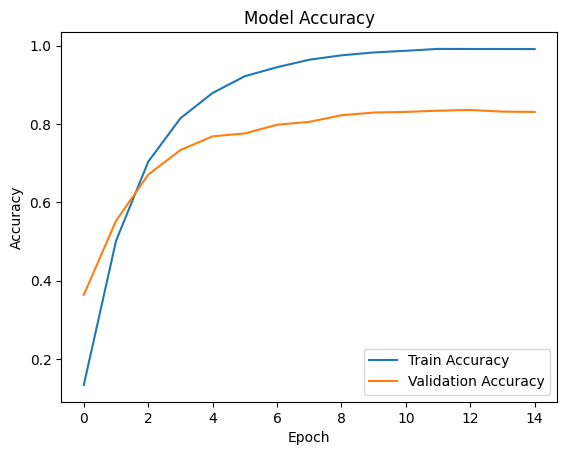

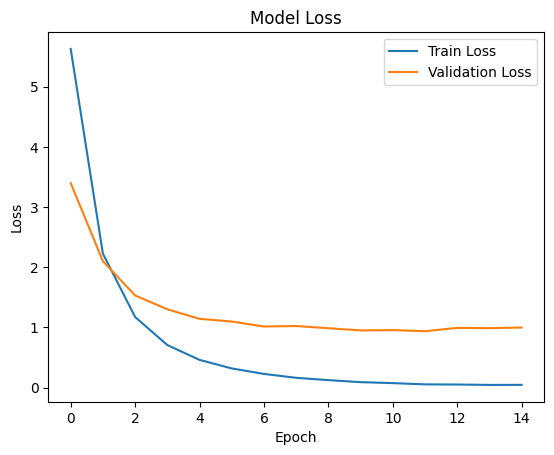

In [31]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 294.69026470184326 
Inference Time: 2.6394667625427246


# **Inceptionv3** # 

In [33]:
from tensorflow.keras.applications import InceptionV3
# Load InceptionV3 with pre-trained weights, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output layer

# Create the final model
InceptionV3model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
InceptionV3model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [35]:
start_time = time.time()

history = InceptionV3model.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.0189 - loss: 6.8807 - val_accuracy: 0.1782 - val_loss: 4.8711
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.1967 - loss: 4.1304 - val_accuracy: 0.3286 - val_loss: 3.3383
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.3546 - loss: 2.7744 - val_accuracy: 0.4329 - val_loss: 2.6911
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4611 - loss: 2.1449 - val_accuracy: 0.5001 - val_loss: 2.3500
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5336 - loss: 1.7557 - val_accuracy: 0.5461 - val_loss: 2.1239
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5889 - loss: 1.4780 - val_accuracy: 0.5808 - val_loss: 1.9288
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.6402 - loss: 1.2540 - val_accuracy: 0.6107 - val_loss: 1.8305
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6700 - loss: 1.1145 - val

In [36]:
InceptionV3model.save("InceptionNet.h5")

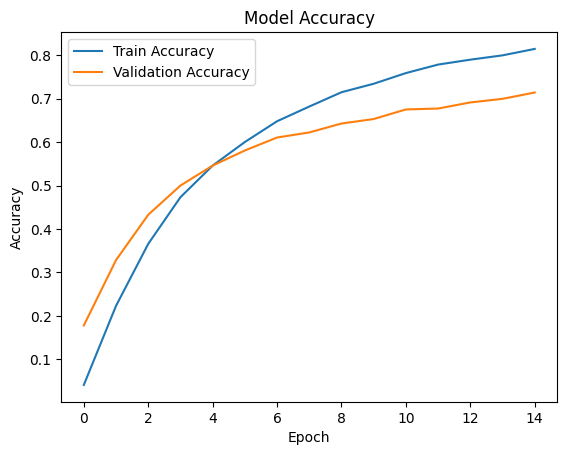

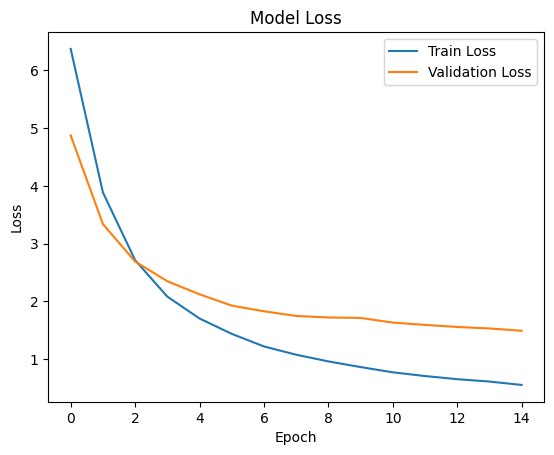

In [37]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
start_time = time.time()

pred = InceptionV3model.predict(np.expand_dims(xtest[0], axis=0))

end_time = time.time()
inference_time = end_time - start_time

y_pred = InceptionV3model.predict(xtest)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step
Weighted Average F1 Score: 0.7040


In [39]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 173.301673412323 
Inference Time: 5.890120029449463


# Custom Cnn

In [40]:
# custom cnn

CustomModel = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(1024, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(2048, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1000, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
CustomModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
start_time = time.time()

history = CustomModel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 7.5379e-04 - loss: 6.8961 - val_accuracy: 0.0015 - val_loss: 6.9119
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 9.7594e-04 - loss: 6.8862 - val_accuracy: 0.0016 - val_loss: 6.9105
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.0012 - loss: 6.9066 - val_accuracy: 0.0013 - val_loss: 6.8740
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 9.6197e-04 - loss: 6.8941 - val_accuracy: 7.7861e-04 - val_loss: 6.9135
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.0011 - loss: 6.8937 - val_accuracy: 7.7861e-04 - val_loss: 6.9340
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 9.8516e-04 - loss: 6.9054 - val_accuracy: 5.1908e-04 - val_loss: 6.9200
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 9.8735e-04 - loss: 6.9195 - val_accuracy: 7.7861e-04 - val_loss: 6.8909
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step 

In [43]:
CustomModel.save("CustomNet.h5")

In [44]:
start_time = time.time()

pred = CustomModel.predict(np.expand_dims(xtest[0], axis=0))

end_time = time.time()
inference_time = end_time - start_time

y_pred = CustomModel.predict(xtest)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Weighted Average F1 Score: 0.0000


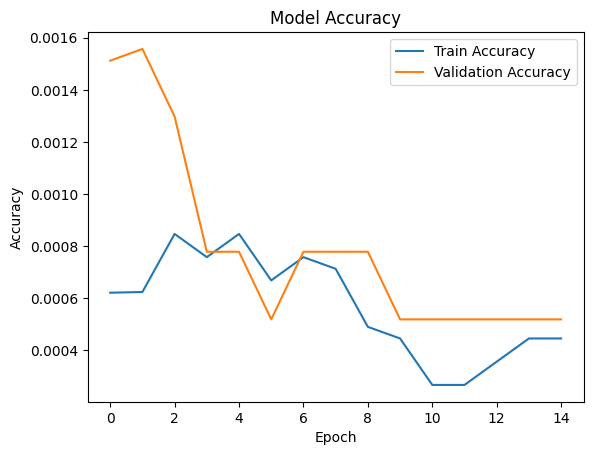

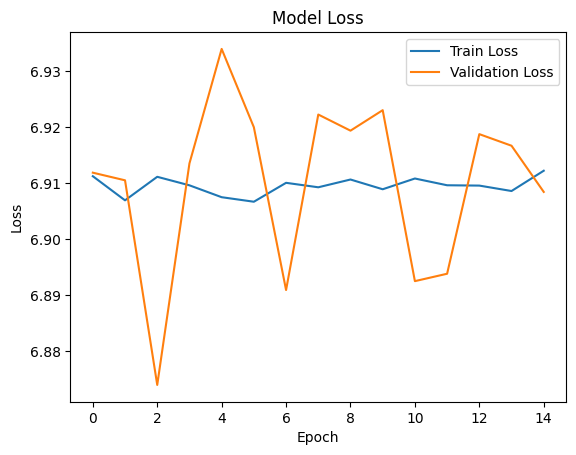

In [45]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 186.97227430343628 
Inference Time: 0.8245117664337158


# MobileNet

In [47]:
from tensorflow.keras.applications import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output layer

# Create the final model
MobileNetmodel = Model(inputs=base_model.input, outputs=predictions)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
MobileNetmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
start_time = time.time()

history = MobileNetmodel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.1213 - loss: 6.0482 - val_accuracy: 0.6935 - val_loss: 1.4262
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7743 - loss: 0.9530 - val_accuracy: 0.8435 - val_loss: 0.6922
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8986 - loss: 0.3902 - val_accuracy: 0.8897 - val_loss: 0.5010
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9452 - loss: 0.2131 - val_accuracy: 0.9099 - val_loss: 0.4246
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9707 - loss: 0.1307 - val_accuracy: 0.9188 - val_loss: 0.3975
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9813 - loss: 0.0839 - val_accuracy: 0.9232 - val_loss: 0.3560
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9895 - loss: 0.0595 - val_accuracy: 0.9343 - val_loss: 0.3406
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9928 - loss: 0.0465 - val_acc

In [50]:
MobileNetmodel.save("MobileNet.h5")

In [51]:
start_time = time.time()

pred = MobileNetmodel.predict(np.expand_dims(xtest[0], axis=0))

end_time = time.time()
inference_time = end_time - start_time

y_pred = MobileNetmodel.predict(xtest)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Weighted Average F1 Score: 0.9239


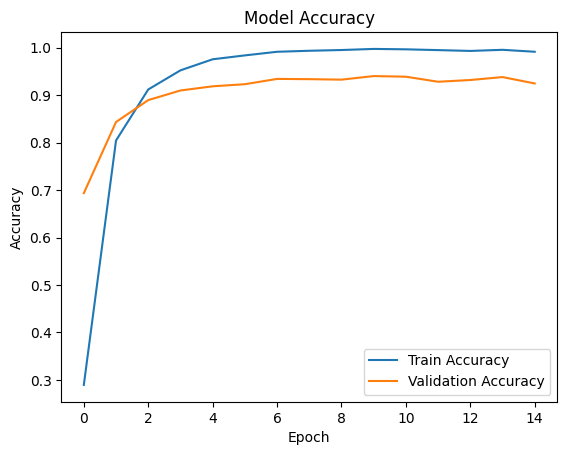

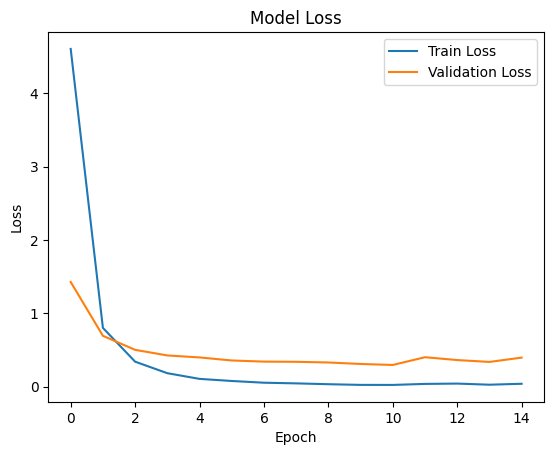

In [52]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 93.55301332473755 
Inference Time: 1.6811821460723877


# Nasnet (Mobile)

In [54]:
from tensorflow.keras.applications import NASNetMobile
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output layer

# Create the final model
NASNetMobilemodel = Model(inputs=base_model.input, outputs=predictions)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [55]:
NASNetMobilemodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
start_time = time.time()

history = NASNetMobilemodel.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 50s 127ms/step - accuracy: 0.0628 - loss: 6.4599 - val_accuracy: 0.3380 - val_loss: 3.7340
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 28s 103ms/step - accuracy: 0.4640 - loss: 2.7028 - val_accuracy: 0.5082 - val_loss: 2.3936
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.6617 - loss: 1.4876 - val_accuracy: 0.5912 - val_loss: 1.8896
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.7679 - loss: 0.9754 - val_accuracy: 0.6608 - val_loss: 1.6019
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.8302 - loss: 0.6986 - val_accuracy: 0.6841 - val_loss: 1.5256
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.8721 - loss: 0.5197 - val_accuracy: 0.7062 - val_loss: 1.4301
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9012 - loss: 0.4027 - val_accuracy: 0.7392 - val_loss: 1.3012
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.9240 - loss: 0.3123 

In [57]:
NASNetMobilemodel.save("NASNetMobile.h5")

In [58]:
start_time = time.time()

pred = NASNetMobilemodel.predict(np.expand_dims(xtest[0], axis=0))

end_time = time.time()
inference_time = end_time - start_time

y_pred = NASNetMobilemodel.predict(xtest)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step
Weighted Average F1 Score: 0.7773


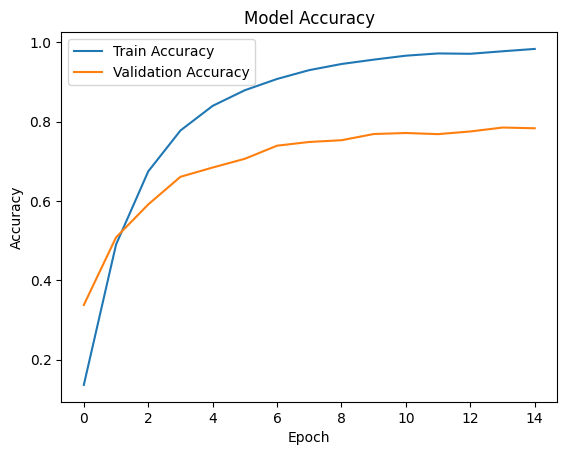

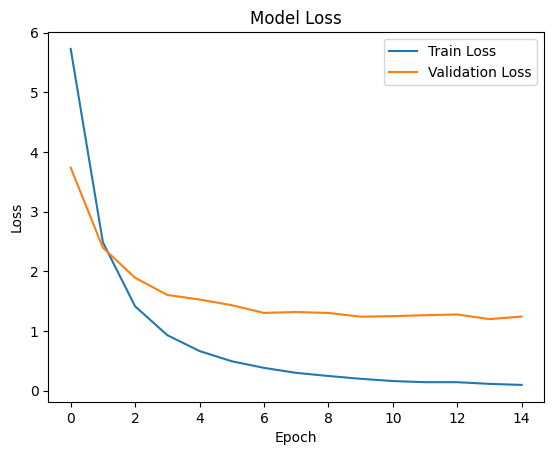

In [59]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 229.45405173301697 
Inference Time: 12.202309846878052


# Resnet 50

In [61]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output

# Create the final model
ResNet50model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [62]:
ResNet50model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [63]:
start_time = time.time()

history = ResNet50model.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step - accuracy: 0.0015 - loss: 6.9634 - val_accuracy: 0.0028 - val_loss: 6.8533
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.0025 - loss: 6.8017 - val_accuracy: 0.0036 - val_loss: 6.7561
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.0026 - loss: 6.7340 - val_accuracy: 0.0036 - val_loss: 6.6609
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.0030 - loss: 6.6606 - val_accuracy: 0.0036 - val_loss: 6.6405
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.0044 - loss: 6.6024 - val_accuracy: 0.0055 - val_loss: 6.6080
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.0049 - loss: 6.5543 - val_accuracy: 0.0080 - val_loss: 6.5293
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.0072 - loss: 6.5049 - val_accuracy: 0.0125 - val_loss: 6.4457
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.0070 - loss: 6.4504 - 

In [64]:
ResNet50model.save("ResNet50.h5")

In [65]:
start_time = time.time()

pred = ResNet50model.predict(np.expand_dims(xtest[0], axis=0))

end_time = time.time()
inference_time = end_time - start_time

y_pred = ResNet50model.predict(xtest)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
Weighted Average F1 Score: 0.0137


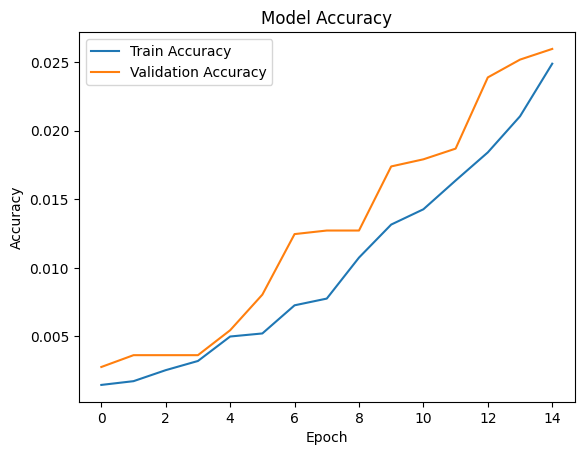

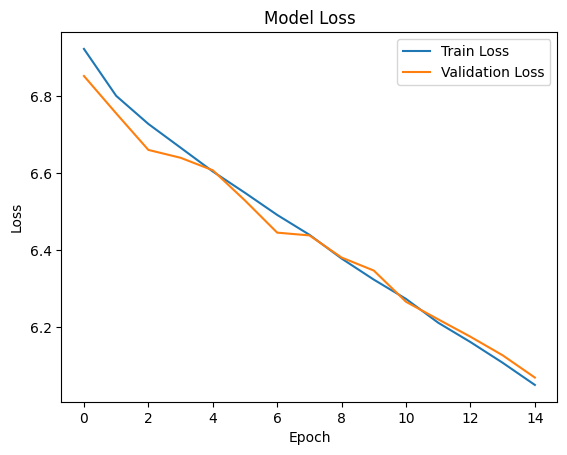

In [66]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 202.72238969802856 
Inference Time: 3.4675629138946533


# Vgg 16

In [68]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x) # Dropout to reduce overfitting
predictions = Dense(1000, activation='softmax')(x)  # Output

# Create the final model
VGG16model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [69]:
VGG16model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
start_time = time.time()

history = VGG16model.fit(
    image_generator(xtrain, ytrain, batch_size=128, class_weights=class_weights_dict),
    steps_per_epoch=len(xtrain) // 128,  
    epochs=15,
    validation_data=image_generator(xtest, ytest, batch_size=128, class_weights=class_weights_dict),
    validation_steps=len(xtest) // 128   
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.0088 - loss: 6.8501 - val_accuracy: 0.0844 - val_loss: 5.9733
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.0851 - loss: 5.4850 - val_accuracy: 0.2188 - val_loss: 4.4276
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.2259 - loss: 4.0304 - val_accuracy: 0.3358 - val_loss: 3.4501
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.3645 - loss: 3.0919 - val_accuracy: 0.4173 - val_loss: 2.8466
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.4562 - loss: 2.5175 - val_accuracy: 0.4869 - val_loss: 2.4206
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5325 - loss: 2.0937 - val_accuracy: 0.5409 - val_loss: 2.1020
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.5923 - loss: 1.7974 - val_accuracy: 0.5873 - val_loss: 1.8565
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.6348 - loss: 1.5828 

In [71]:
VGG16model.save("Vgg16.h5")

In [72]:
start_time = time.time()

pred = VGG16model.predict(np.expand_dims(xtest[0], axis=0))

end_time = time.time()
inference_time = end_time - start_time

y_pred = VGG16model.predict(xtest)
y_pred = y_pred.argmax(axis=1) 
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
Weighted Average F1 Score: 0.7453


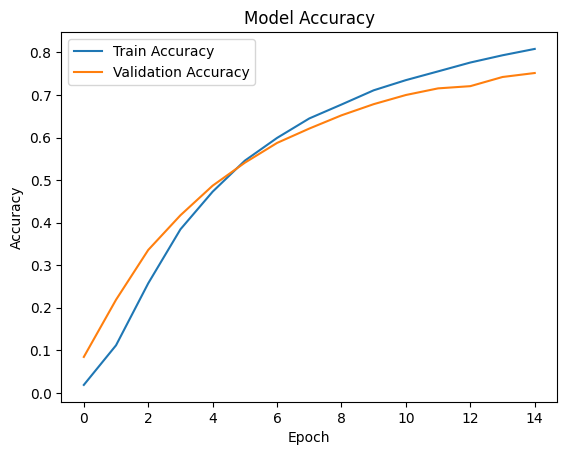

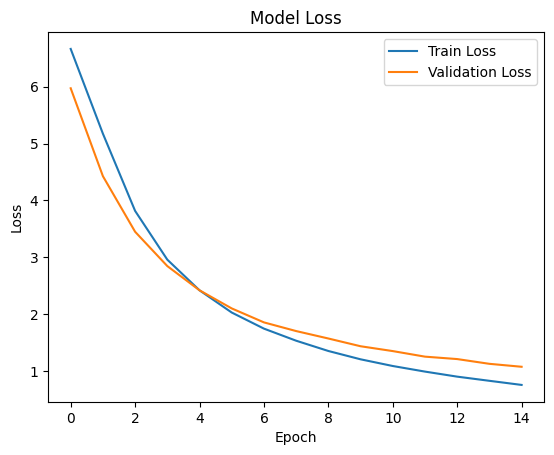

In [73]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
print("Training time:", training_time,"\nInference Time:", inference_time)

Training time: 272.4031090736389 
Inference Time: 1.0029833316802979
